In [119]:
# %load imports.py
%load_ext autoreload
%autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
import brian2 as br
from brian2.units import *
import numpy as np

In [121]:
import warnings 
def set_parameters_from_dict(neurongroup, dictionary_of_parameters):
    for param_key, param_value in dictionary_of_parameters.items():
        try: 
            neurongroup.__setattr__(param_key, param_value)
        except AttributeError as err:
            warnings.warn("{:s} has no paramater {:s}".format(neurongroup.name, param_key))

# Definition of the Neuron and Synapse Model

In [122]:
model_eqs = """
dv/dt =1.0/tau* (-v + u_ext) :volt (unless refractory)
tau :second
u_ext: volt
v_threshold: volt
v_reset: volt
tau_refractory: second
"""

delta_synapse_model = 'w: volt'
delta_synapse = 'v+=w'

threshold = "v>v_threshold"
reset = "v=v_reset"
refractory = "tau_refractory"

neuron_properties = {
    "tau": 10*ms,
    "v_threshold": -40*mV,
    "v_reset": -75*mV,
    "tau_refractory": 0.5*ms,
    "u_ext": - 39 * mV
}

pulse_strength = -60. * mV


## Analysis Functions for the Spike Train

In [123]:
def get_spike_train(delay, pulse_strength):
    neuron = br.NeuronGroup(N=1, \
                                        name='single_neuron',\
                                        model=model_eqs, \
                                       threshold=threshold, \
                                       reset=reset,\
                                       refractory = refractory)

    set_parameters_from_dict(neuron, neuron_properties)
    neuron.v = neuron_properties["v_reset"]

    spike_recorder = br.SpikeMonitor(source=neuron)

    auto_synapse = br.Synapses(source=neuron, target=neuron, model=delta_synapse_model, on_pre = delta_synapse, delay = delay)
    auto_synapse.connect()
    auto_synapse.w = pulse_strength
    
    net = br.Network(neuron)
    net.add(auto_synapse)
    net.add(spike_recorder)
    net.run(duration=duration)
    
    spike_train = spike_recorder.spike_trains()
    return spike_train


In [124]:
def get_mean_period(spike_train):
    return (np.max(spike_train[0]) - np.min(spike_train[0])) / (spike_train[0].shape[0] - 1)

In [125]:
def get_mean_response(spike_trains_dict,t_isi):
    mean_response_dict = {}
#     t_isi = get_mean_period(spike_trains_dict[0.0 * ms])
    for delay, spike_train in spike_trains_dict.items():
        mean_response_dict[delay] = get_mean_period(spike_train) - t_isi
    return mean_response_dict

## Plotting Functions

In [126]:
import matplotlib.pyplot as plt

In [127]:
def plot_spiking(spike_trains_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for key, times in spike_trains_dict.items():
        ax.plot(times[0]/ms, key*np.ones(times[0].shape), 'b.')
#     ax.plot(spike_train[0]/ms, np.ones(spike_train[0].shape), 'b|')

    ax.grid(axis='x')
#     ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel("Time(ms)");

In [128]:
def plot_mean_period(mean_period_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(list(mean_period_dict.keys()), list(mean_period_dict.values()), 'b')

    ax.grid(axis='x')
    ax.set_xlabel("Delay (ms)");

In [129]:
def plot_mean_response(mean_response_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.array(list(mean_response_dict.keys())), 1e3*np.array(list(mean_response_dict.values())), 'b')
    ax.plot(list(mean_response_dict.keys()), list(mean_response_dict.keys()), 'k--')

    ax.grid(axis='x')
    ax.set_xlabel("t_inh (ms)")
    ax.set_ylabel("exc_spike_delay (ms)");

In [130]:
def plot_delay_minus_response(mean_response_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    print(np.array(list(mean_response_dict.keys())))
    print(np.array(list(mean_response_dict.values())))
    print(np.array(list(mean_response_dict.keys()))-np.array(list(mean_response_dict.values())))
    ax.plot(list(mean_response_dict.keys()), np.array(list(mean_response_dict.keys()))-1e3*np.array(list(mean_response_dict.values())), 'b')

    ax.grid(axis='x')
    ax.set_xlabel("Delay (ms)");

In [131]:
def plot_phase_response_curve(mean_response_dict, t_isi):
    
    phi_inh = np.array(list(mean_response_dict.keys())) * ms / t_isi
    delta_phi = -np.array(list(mean_response_dict.values())) * second / t_isi
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(phi_inh, delta_phi, 'b')
    ax.plot(phi_inh, -phi_inh, 'k--')

    ax.grid(axis='x')
    ax.set_xlabel("phase of inhibition (ms)")
    ax.set_ylabel("phase shift (ms)");

## Execution

In [132]:
duration = 1000*ms
n_simulations = 100

t_isi = get_mean_period(get_spike_train(0.0 * ms,0.0))

delay_list = np.linspace(0.0 * ms,t_isi,n_simulations)
spike_trains_dict = {}

for delay in delay_list:
    spike_train = get_spike_train(delay, pulse_strength)
    spike_trains_dict[delay/ms] = spike_train

In [133]:
# mean_response_dict = get_mean_response(spike_trains_dict, t_isi)
# plot_mean_response(mean_response_dict)

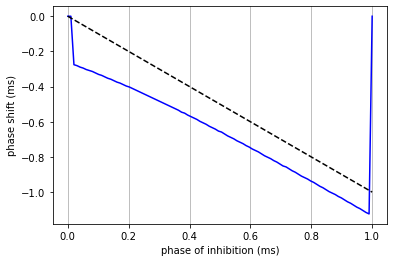

In [134]:
plot_phase_response_curve(mean_response_dict, t_isi)

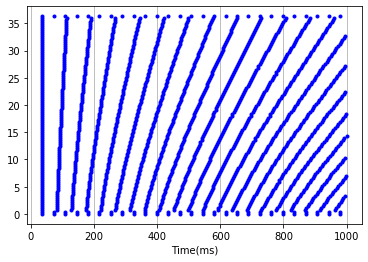

In [135]:
plot_spiking(spike_trains_dict)